In [99]:
import requests
import pandas as pd
import seaborn as sns

from dotenv import load_dotenv
load_dotenv()

import os

In [100]:
TRAFIKVERKET_API=os.getenv("TRAFIKVERKET_KEY")
TRAFIKVERKET_URL="https://api.trafikinfo.trafikverket.se/v2/data.json"

In [131]:
def get_data(question: str):
    headers = {
        "Content-Type": "text/xml"
    }
    resp = requests.post(TRAFIKVERKET_URL, data=question, headers=headers)

    return resp.json()['RESPONSE']['RESULT'][0]

In [145]:
all_locations = get_data(
    """
    <REQUEST>
        <LOGIN authenticationkey="e4f6b2548ecc4400b9fc59c4a4710fe8"/>
        <QUERY objecttype="TrainStation" namespace="rail.infrastructure" schemaversion="1.5" limit="10000">
            <FILTER></FILTER>
            <INCLUDE>AdvertisedLocationName</INCLUDE>
            <INCLUDE>LocationSignature</INCLUDE>
        </QUERY>
    </REQUEST>
    """
)

df_locations = pd.DataFrame(all_locations['TrainStation'])
df_locations['AdvertisedLocationName'] = df_locations['AdvertisedLocationName'].str.lower()

def get_signature(location: str):
    return df_locations[df_locations['AdvertisedLocationName'].str.find(location) > -1]['LocationSignature'].values


In [151]:
def get_data_for_station(location_name: str):
    location = get_signature(location_name)
    if len(location) == 0:
        return None
    location = location[0]
    question = f"""<REQUEST>
        <LOGIN authenticationkey="{TRAFIKVERKET_API}"/>
        <QUERY objecttype="TrainAnnouncement" schemaversion="1.9" limit="1000">
            <FILTER>
            <EQ name="LocationSignature" value="{location}" />
            <GT name="AdvertisedTimeAtLocation" value="$dateadd(-1)" />
            <LT name="AdvertisedTimeAtLocation" value="$now" />
            </FILTER>
        </QUERY>
    </REQUEST>"""

    return get_data(question)

# trainstation_question = f"""<REQUEST>
#   <LOGIN authenticationkey="{TRAFIKVERKET_API}"/>
#   <QUERY objecttype="TrainAnnouncement" schemaversion="1.9" limit="1000">
#     <FILTER>
#       <EQ name="LocationSignature" value="Cst" />
#       <GT name="AdvertisedTimeAtLocation" value="$dateadd(-1)" />
#       <LT name="AdvertisedTimeAtLocation" value="$now" />
#     </FILTER>
#   </QUERY>
# </REQUEST>"""

# trainstation_question

In [152]:
traininfo = get_data_for_station("stockholm c")

traininfo

{'TrainAnnouncement': [{'ActivityId': '1500adde-f75d-c409-08dc-5438b8041207',
   'ActivityType': 'Ankomst',
   'Advertised': True,
   'AdvertisedTimeAtLocation': '2024-04-19T17:05:00.000+02:00',
   'AdvertisedTrainIdent': '20954',
   'Canceled': False,
   'Deleted': False,
   'DepartureDateOTN': '2024-04-19T00:00:00.000+02:00',
   'EstimatedTimeIsPreliminary': False,
   'FromLocation': [{'LocationName': 'Öb', 'Priority': 1, 'Order': 0}],
   'InformationOwner': 'Mälardalstrafik AB',
   'LocationDateTimeOTN': '2024-04-19T17:05:00.000+02:00',
   'LocationSignature': 'Cst',
   'ModifiedTime': '2024-04-19T15:05:32.311Z',
   'NewEquipment': 0,
   'Operator': 'MTRN',
   'OperationalTrainNumber': '20954',
   'OperationalTransportIdentifiers': [{'ObjectType': 'PR',
     'Company': '0074',
     'Core': '----LTP36907',
     'Variant': '00',
     'TimetableYear': 2024,
     'StartDate': '2024-04-19'},
    {'ObjectType': 'TR',
     'Company': '3999',
     'Core': '---------954',
     'Variant': '00

In [154]:
len (traininfo['TrainAnnouncement'])

773

In [155]:
df = pd.DataFrame(traininfo["TrainAnnouncement"])

df.head(1)
df.shape

(773, 38)

In [156]:
df = df[['AdvertisedTimeAtLocation', 'TimeAtLocation', 'ActivityType']]

df['AdvertisedTimeAtLocation'] = pd.to_datetime(df['AdvertisedTimeAtLocation'])
df['TimeAtLocation'] = pd.to_datetime(df['TimeAtLocation'])

df.loc[:, 'Delay'] = (df['TimeAtLocation'] - df['AdvertisedTimeAtLocation']).dt.total_seconds() / 60

# df.mean()

<Axes: xlabel='AdvertisedTimeAtLocation'>

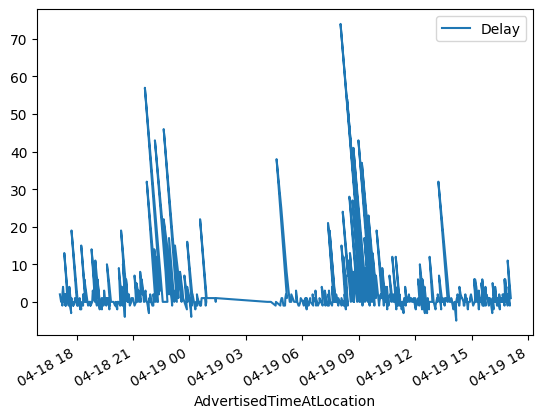

In [157]:
df.plot(x='AdvertisedTimeAtLocation', y='Delay')

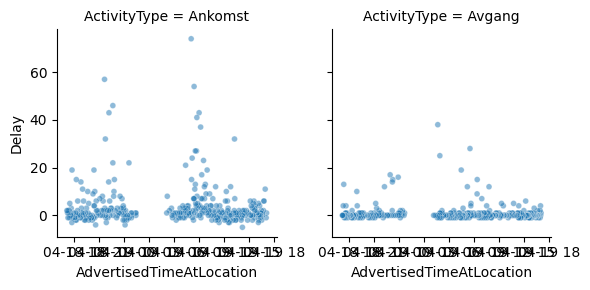

In [158]:
g = sns.FacetGrid(df, col='ActivityType')
g.map(sns.scatterplot, 'AdvertisedTimeAtLocation', 'Delay', alpha=0.5, size=0.1)

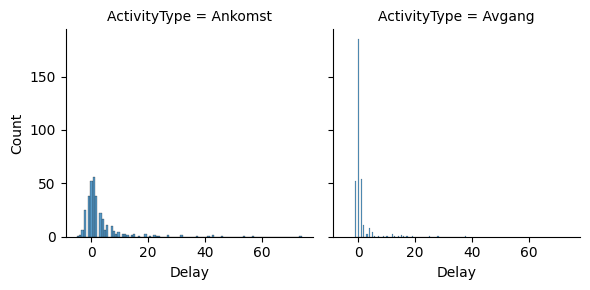

In [159]:
g = sns.FacetGrid(df, col='ActivityType')
g.map(sns.histplot, 'Delay', bins=100)